# Feature Engineering Deep Dive

**Author:** Alexis Alduncin (Data Scientist)
**Team:** MLOps 62

This notebook demonstrates the detailed feature engineering process, showing before/after comparisons for each engineered feature and their impact on the prediction task.

In [1]:
# Setup and imports
import sys
import os

# Add project root to path (handles both Docker /work and local environments)
if os.path.exists('/work'):
    sys.path.insert(0, '/work')  # Docker environment
else:
    sys.path.insert(0, os.path.abspath('..'))  # Local environment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from src import config
from src.data_utils import load_data
from src.plots import plot_categorical_analysis, plot_numerical_relationship

# Import Phase 1 feature engine (from features.py file, not features/ directory)
import importlib
features_module = importlib.import_module('src.features_engine')
AbsenteeismFeatureEngine = features_module.AbsenteeismFeatureEngine

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Modules imported successfully")
print(f"Target Column: {config.TARGET_COLUMN}")

✅ Modules imported successfully
Target Column: Absenteeism time in hours


## 1. Load and Prepare Data

In [2]:
# Load raw data using team's robust DVC approach
df_raw = load_data(config.RAW_DATA_PATH)
print(f"Raw data loaded: {df_raw.shape}")

# Initialize feature engine
engine = AbsenteeismFeatureEngine()

# Clean data first
df = engine.clean_data(df_raw)
print(f"Cleaned data: {df.shape}")
print(f"Records removed: {len(df_raw) - len(df)} ({(len(df_raw)-len(df))/len(df_raw)*100:.1f}%)")

df.head()

2025-11-18 02:28:44,059 - src.data_utils - INFO - Detected Docker environment: /work
2025-11-18 02:28:44,060 - src.data_utils - INFO - Repository ready: /work
2025-11-18 02:28:44,061 - src.data_utils - INFO - Reading local file (MD5 verified): /work/data/raw/work_absenteeism_modified.csv
2025-11-18 02:28:44,064 - src.data_utils - INFO - Loaded from local: (754, 22)
2025-11-18 02:28:44,064 - src.data_utils - INFO - Data loaded from local: (754, 22)
2025-11-18 02:28:44,065 - src.features_engine - INFO - Starting data cleaning...
2025-11-18 02:28:44,073 - src.features_engine - INFO - Removed 23 outliers (>120 hours)
2025-11-18 02:28:44,074 - src.features_engine - INFO - Data cleaning complete. Final shape: (713, 22)


Raw data loaded: (754, 22)
Cleaned data: (713, 22)
Records removed: 41 (5.4%)


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,mixed_type_col
0,11,26.0,7.0,3.0,1.0,289.0,36.0,13.0,33.0,239.554,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0,535.0
1,36,28.0,7.0,3.0,1.0,118.0,13.0,18.0,50.0,239.554,...,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0,584.0
2,3,23.0,7.0,4.0,1.0,179.0,51.0,18.0,38.0,239.554,...,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0,249.0
3,7,7.0,7.0,5.0,1.0,279.0,5.0,14.0,39.0,239.554,...,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0,538.0
6,10,22.0,7.0,6.0,1.0,361.0,52.0,3.0,28.0,239.554,...,1.0,1.0,1.0,0.0,NaN,80.0,172.0,27.0,8.0,91.0


## 2. Feature 1: Absence Categories

**Purpose:** Bin continuous absenteeism hours into meaningful categories for classification tasks and better pattern recognition.

**Bins:**
- **Short** (0-4h): Minor absences
- **Half_Day** (4-8h): Half-day absences
- **Full_Day** (8-24h): Full-day absences
- **Extended** (24-120h): Multi-day medical leave

2025-11-18 02:28:46,248 - src.features_engine - INFO - Created Absence_Category feature


Absence Category Distribution:
Short       444
Half_Day    208
Full_Day     34
Extended     27
Name: Absence_Category, dtype: int64

Percentage Distribution:
Short       62.272090
Half_Day    29.172511
Full_Day     4.768583
Extended     3.786816
Name: Absence_Category, dtype: float64


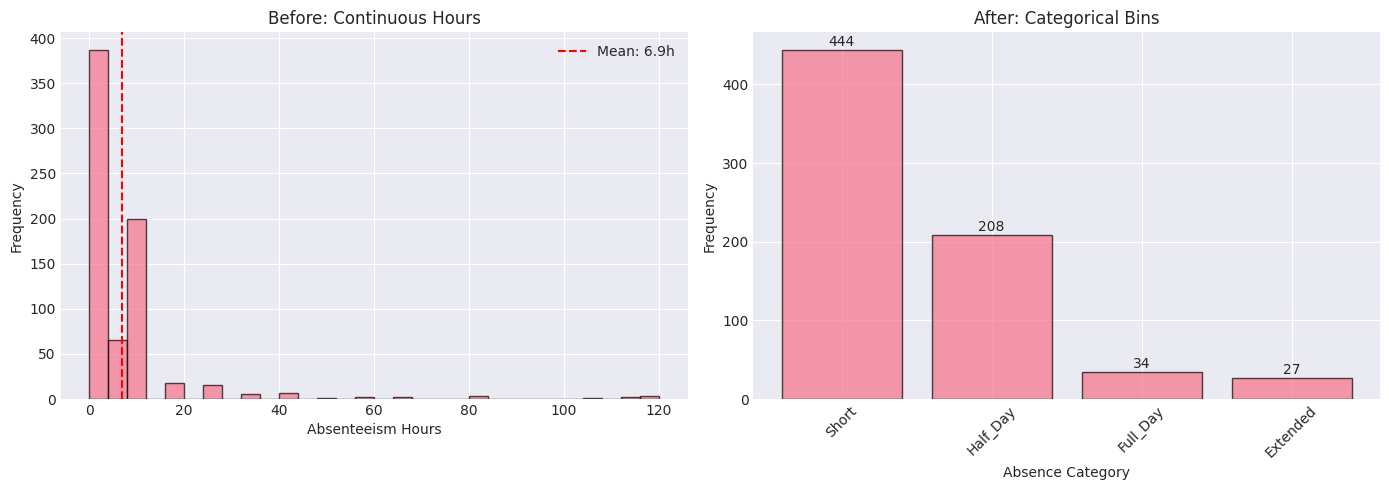


✅ Absence categories created successfully


In [3]:
# Create absence categories
df_absence = engine.create_absence_categories(df.copy())

# Show distribution
print("Absence Category Distribution:")
print(df_absence['Absence_Category'].value_counts().sort_index())
print(f"\nPercentage Distribution:")
print(df_absence['Absence_Category'].value_counts(normalize=True).sort_index() * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before: Continuous distribution
axes[0].hist(df[config.TARGET_COLUMN], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Absenteeism Hours')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Before: Continuous Hours')
axes[0].axvline(df[config.TARGET_COLUMN].mean(), color='red', linestyle='--', label=f'Mean: {df[config.TARGET_COLUMN].mean():.1f}h')
axes[0].legend()

# After: Categorical distribution
category_counts = df_absence['Absence_Category'].value_counts().sort_index()
axes[1].bar(range(len(category_counts)), category_counts.values, edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(category_counts)))
axes[1].set_xticklabels(category_counts.index, rotation=45)
axes[1].set_xlabel('Absence Category')
axes[1].set_ylabel('Frequency')
axes[1].set_title('After: Categorical Bins')

for i, v in enumerate(category_counts.values):
    axes[1].text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

print("\n✅ Absence categories created successfully")

## 3. Feature 2: BMI Categories

**Purpose:** Convert continuous BMI to WHO-standard health categories to capture non-linear health risk patterns.

**Categories (WHO Standard):**
- **Underweight**: BMI < 18.5
- **Normal**: 18.5 ≤ BMI < 25
- **Overweight**: 25 ≤ BMI < 30
- **Obese**: BMI ≥ 30

2025-11-18 02:28:48,066 - src.features_engine - INFO - Created BMI_Category feature
2025-11-18 02:28:48,072 - src.plots - INFO - Creating categorical analysis for BMI_Category


BMI Category Distribution:
Underweight      0
Normal         252
Overweight     221
Obese          233
Name: BMI_Category, dtype: int64

Percentage Distribution:
Underweight     0.000000
Normal         35.694051
Overweight     31.303116
Obese          33.002833
Name: BMI_Category, dtype: float64

Average Absenteeism by BMI Category:
                  mean  median        std  count
BMI_Category                                    
Underweight        NaN     NaN        NaN      0
Normal        6.674603     3.0  14.013840    252
Overweight    8.239819     4.0  13.854486    221
Obese         6.030043     3.0  12.358996    233


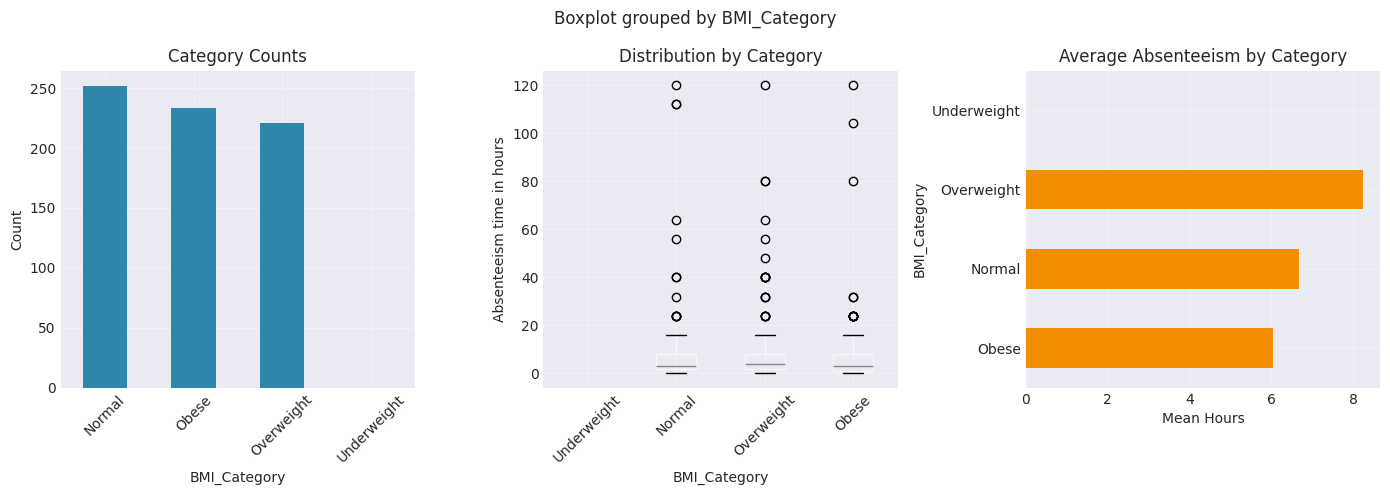


✅ BMI categories created - reveals health-related absence patterns


In [4]:
# Create BMI categories
df_bmi = engine.create_bmi_categories(df.copy())

# Show distribution
print("BMI Category Distribution:")
print(df_bmi['BMI_Category'].value_counts().sort_index())
print(f"\nPercentage Distribution:")
print(df_bmi['BMI_Category'].value_counts(normalize=True).sort_index() * 100)

# Statistical analysis by category
print("\nAverage Absenteeism by BMI Category:")
bmi_stats = df_bmi.groupby('BMI_Category')[config.TARGET_COLUMN].agg(['mean', 'median', 'std', 'count'])
print(bmi_stats)

# Visualize
fig = plot_categorical_analysis(df_bmi, 'BMI_Category', config.TARGET_COLUMN)
plt.show()

print("\n✅ BMI categories created - reveals health-related absence patterns")

## 4. Feature 3: Age Groups

**Purpose:** Segment employees by age to capture life-stage specific absence patterns.

**Groups:**
- **Young** (18-30): Early career
- **Middle** (30-45): Mid-career with family responsibilities
- **Senior** (45-60): Late career
- **Veteran** (60+): Near retirement

2025-11-18 02:28:49,352 - src.features_engine - INFO - Created Age_Group feature


Age Group Distribution:
Young      168
Middle     398
Senior     126
Veteran     10
Name: Age_Group, dtype: int64

Percentage Distribution:
Young      23.931624
Middle     56.695157
Senior     17.948718
Veteran     1.424501
Name: Age_Group, dtype: float64


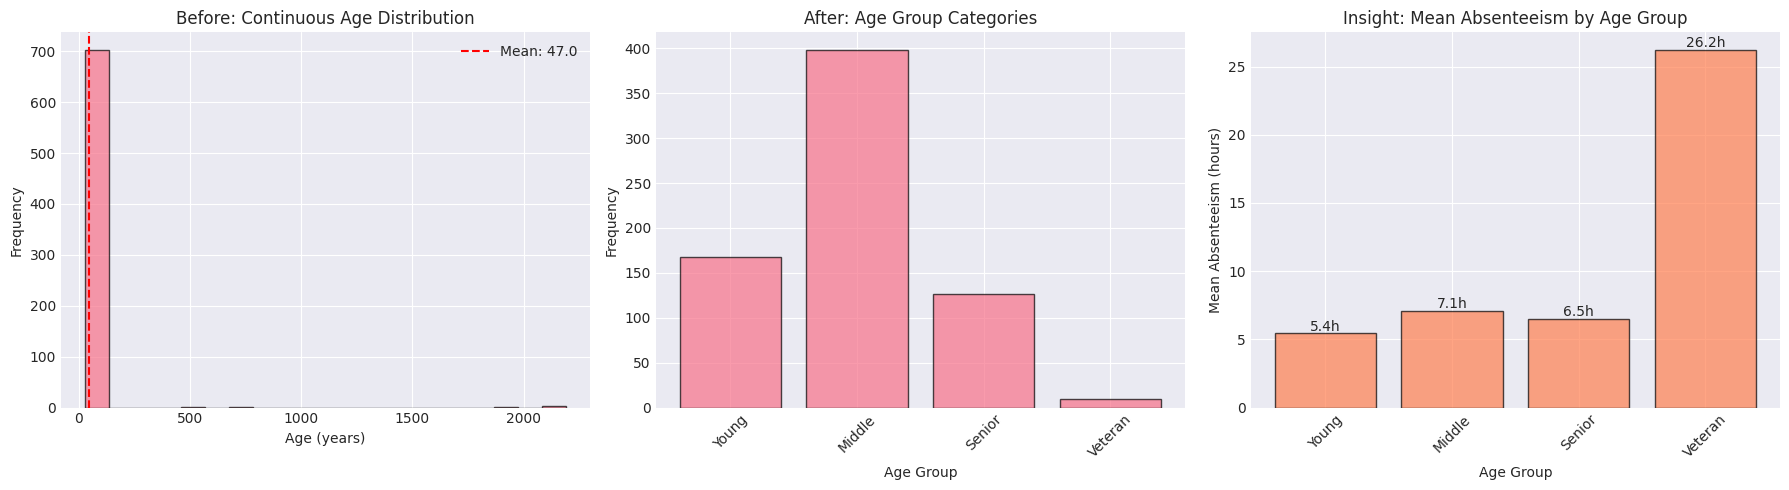


✅ Age groups created - captures life-stage absence patterns


In [5]:
# Create age groups
df_age = engine.create_age_groups(df.copy())

# Show distribution
print("Age Group Distribution:")
print(df_age['Age_Group'].value_counts().sort_index())
print(f"\nPercentage Distribution:")
print(df_age['Age_Group'].value_counts(normalize=True).sort_index() * 100)

# Compare continuous vs categorical
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Continuous age distribution
axes[0].hist(df['Age'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Before: Continuous Age Distribution')
axes[0].axvline(df['Age'].mean(), color='red', linestyle='--', label=f'Mean: {df["Age"].mean():.1f}')
axes[0].legend()

# Categorical age groups
age_counts = df_age['Age_Group'].value_counts().sort_index()
axes[1].bar(range(len(age_counts)), age_counts.values, edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(age_counts)))
axes[1].set_xticklabels(age_counts.index, rotation=45)
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Frequency')
axes[1].set_title('After: Age Group Categories')

# Absenteeism by age group
age_absence = df_age.groupby('Age_Group')[config.TARGET_COLUMN].mean().sort_index()
axes[2].bar(range(len(age_absence)), age_absence.values, edgecolor='black', alpha=0.7, color='coral')
axes[2].set_xticks(range(len(age_absence)))
axes[2].set_xticklabels(age_absence.index, rotation=45)
axes[2].set_xlabel('Age Group')
axes[2].set_ylabel('Mean Absenteeism (hours)')
axes[2].set_title('Insight: Mean Absenteeism by Age Group')

for i, v in enumerate(age_absence.values):
    axes[2].text(i, v + 0.2, f'{v:.1f}h', ha='center')

plt.tight_layout()
plt.show()

print("\n✅ Age groups created - captures life-stage absence patterns")

## 5. Feature 4: Distance Categories

**Purpose:** Categorize commute distance to capture transportation-related absence patterns.

**Categories:**
- **Near** (0-10 km): Short commute
- **Moderate** (10-25 km): Medium commute
- **Far** (25-40 km): Long commute
- **Very_Far** (40+ km): Very long commute

2025-11-18 02:28:51,986 - src.features_engine - INFO - Created Distance_Category feature
2025-11-18 02:28:51,989 - src.plots - INFO - Creating categorical analysis for Distance_Category


Distance Category Distribution:
Near         58
Moderate    226
Far         278
Very_Far    137
Name: Distance_Category, dtype: int64

Percentage Distribution:
Near         8.297568
Moderate    32.331903
Far         39.771102
Very_Far    19.599428
Name: Distance_Category, dtype: float64

Average Absenteeism by Distance Category:
                       mean  median  count
Distance_Category                         
Near               6.155172     3.0     58
Moderate           8.973451     4.0    226
Far                6.341727     3.0    278
Very_Far           4.956204     3.0    137


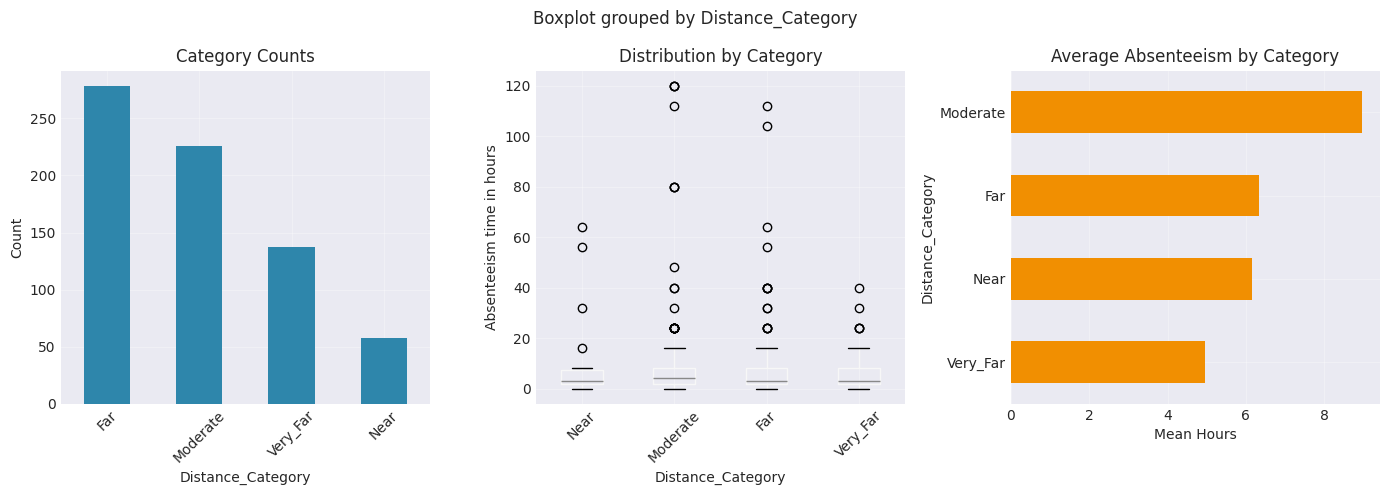


✅ Distance categories created - reveals commute impact on absence


In [6]:
# Create distance categories
df_distance = engine.create_distance_categories(df.copy())

# Show distribution
print("Distance Category Distribution:")
print(df_distance['Distance_Category'].value_counts().sort_index())
print(f"\nPercentage Distribution:")
print(df_distance['Distance_Category'].value_counts(normalize=True).sort_index() * 100)

# Analyze impact on absenteeism
print("\nAverage Absenteeism by Distance Category:")
distance_stats = df_distance.groupby('Distance_Category')[config.TARGET_COLUMN].agg(['mean', 'median', 'count'])
print(distance_stats.sort_index())

# Visualize
fig = plot_categorical_analysis(df_distance, 'Distance_Category', config.TARGET_COLUMN)
plt.show()

print("\n✅ Distance categories created - reveals commute impact on absence")

## 6. Feature 5: Workload Categories

**Purpose:** Segment workload intensity to identify stress-related absence patterns.

**Categories:**
- **Low**: 0-33rd percentile
- **Medium**: 33rd-66th percentile
- **High**: 66th-100th percentile

2025-11-18 02:28:53,742 - src.features_engine - INFO - Created Workload_Category feature
2025-11-18 02:28:53,747 - src.plots - INFO - Creating categorical analysis for Workload_Category


Workload Category Distribution:
Low       223
Medium    308
High      166
Name: Workload_Category, dtype: int64

Percentage Distribution:
Low       31.994261
Medium    44.189383
High      23.816356
Name: Workload_Category, dtype: float64

Workload Thresholds:
Low/Medium boundary (33rd percentile): 251.82
Medium/High boundary (66th percentile): 280.55

Average Absenteeism by Workload:
                       mean  median        std  count
Workload_Category                                    
Low                7.192825     4.0  15.432607    223
Medium             6.305195     3.0  11.922293    308
High               7.313253     3.0  10.413776    166


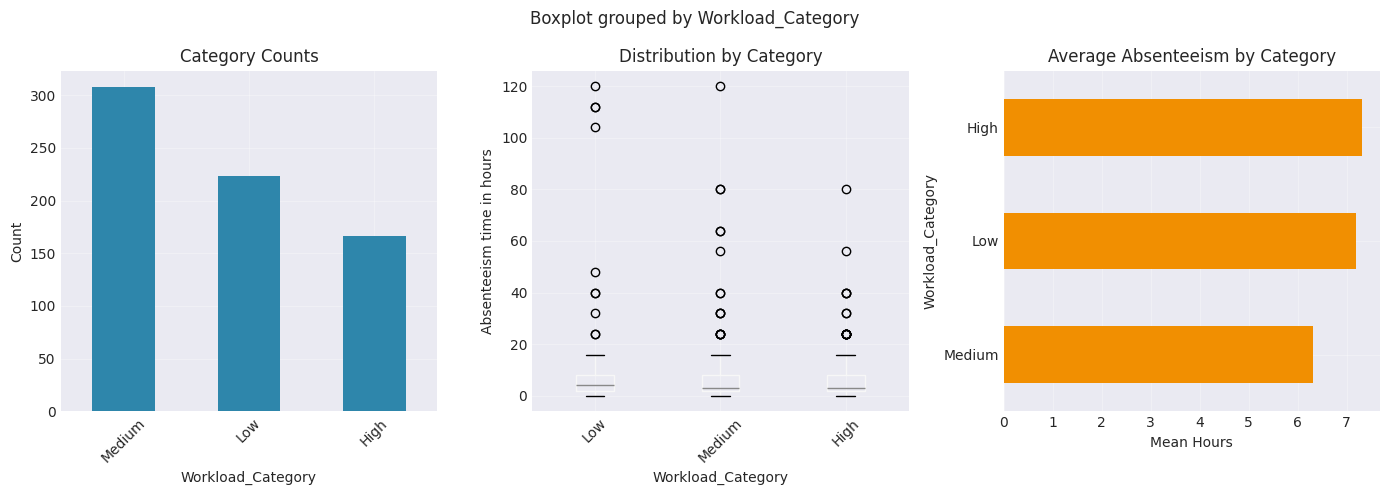


✅ Workload categories created - identifies stress-related absences


In [7]:
# 1) Normalize names of columns
df.columns = (
    df.columns
      .str.strip() # remove spaces
      .str.replace(r"\s+", " ", regex=True)  # remove multimple spaces
)

# 2) Force numerical variable
workload_candidates = ["Work load Average/day", "Work load Average/day "]
workload_col = next((c for c in workload_candidates if c in df.columns), None)
if workload_col is None:
    raise KeyError("No encuentro la columna 'Work load Average/day' (con o sin espacio final).")

df[workload_col] = pd.to_numeric(df[workload_col], errors="coerce")


# Create workload categories
df_workload = engine.create_workload_categories(df.copy())

# Show distribution
print("Workload Category Distribution:")
print(df_workload['Workload_Category'].value_counts().sort_index())
print(f"\nPercentage Distribution:")
print(df_workload['Workload_Category'].value_counts(normalize=True).sort_index() * 100)

# Calculate workload thresholds
print(f"\nWorkload Thresholds:")
print(f"Low/Medium boundary (33rd percentile): {df[workload_col].quantile(0.33):.2f}")
print(f"Medium/High boundary (66th percentile): {df[workload_col].quantile(0.66):.2f}")

# Analyze impact
print("\nAverage Absenteeism by Workload:")
workload_stats = df_workload.groupby('Workload_Category')[config.TARGET_COLUMN].agg(['mean', 'median', 'std', 'count'])
print(workload_stats.reindex(['Low', 'Medium', 'High']))

# Visualize
fig = plot_categorical_analysis(df_workload, 'Workload_Category', config.TARGET_COLUMN)
plt.show()

print("\n✅ Workload categories created - identifies stress-related absences")

## 7. Feature 6: Season Names

**Purpose:** Convert numeric season codes to meaningful names for better interpretability.

**Mapping:**
- 1 → Summer
- 2 → Autumn
- 3 → Winter
- 4 → Spring

2025-11-18 02:28:55,338 - src.features_engine - INFO - Created Season_Name feature


Before: Numeric Seasons
1.0      160
2.0      178
3.0      168
4.0      195
45.0       1
79.0       1
246.0      1
643.0      1
866.0      1
949.0      1
986.0      1
Name: Seasons, dtype: int64

After: Named Seasons
Spring    195
Autumn    178
Winter    168
Summer    160
Name: Season_Name, dtype: int64

Average Absenteeism by Season:
                 mean  median  count
Season_Name                         
Autumn       6.112360     3.0    178
Spring       6.123077     3.0    195
Summer       7.425000     4.0    160
Winter       8.017857     4.0    168


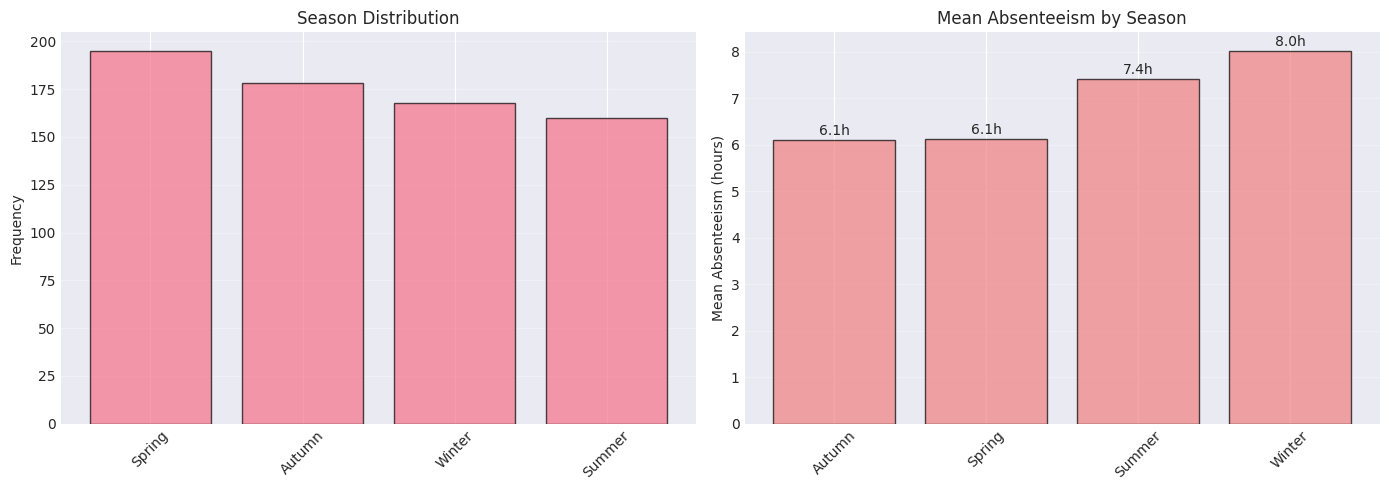


✅ Season names created - improves interpretability


In [8]:
# Create season names
df_season = engine.create_season_names(df.copy())

# Compare before and after
print("Before: Numeric Seasons")
print(df['Seasons'].value_counts().sort_index())

print("\nAfter: Named Seasons")
print(df_season['Season_Name'].value_counts())

# Seasonal analysis
print("\nAverage Absenteeism by Season:")
season_stats = df_season.groupby('Season_Name')[config.TARGET_COLUMN].agg(['mean', 'median', 'count'])
print(season_stats)

# Visualize seasonal patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Season distribution
season_counts = df_season['Season_Name'].value_counts()
axes[0].bar(range(len(season_counts)), season_counts.values, edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(season_counts)))
axes[0].set_xticklabels(season_counts.index, rotation=45)
axes[0].set_ylabel('Frequency')
axes[0].set_title('Season Distribution')
axes[0].grid(axis='y', alpha=0.3)

# Mean absenteeism by season
season_means = df_season.groupby('Season_Name')[config.TARGET_COLUMN].mean()
axes[1].bar(range(len(season_means)), season_means.values, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_xticks(range(len(season_means)))
axes[1].set_xticklabels(season_means.index, rotation=45)
axes[1].set_ylabel('Mean Absenteeism (hours)')
axes[1].set_title('Mean Absenteeism by Season')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(season_means.values):
    axes[1].text(i, v + 0.1, f'{v:.1f}h', ha='center')

plt.tight_layout()
plt.show()

print("\n✅ Season names created - improves interpretability")

## 8. Feature 7: High Risk Flag

**Purpose:** Create composite risk indicator combining multiple high-risk factors.

**High Risk Criteria (any of):**
- Has disciplinary warnings
- BMI in Obese category (≥30)
- Very far commute distance (>40 km)
- Has 3+ children

2025-11-18 02:28:57,391 - src.features_engine - INFO - Created BMI_Category feature
2025-11-18 02:28:57,393 - src.features_engine - INFO - Created Distance_Category feature
2025-11-18 02:28:57,394 - src.features_engine - INFO - Created High_Risk feature


High Risk Flag Distribution:
0    389
1    324
Name: High_Risk, dtype: int64

Percentage High Risk: 45.4%

Absenteeism Comparison:
               mean  median        std  count
Low Risk   8.156812     3.0  15.254662    389
High Risk  5.435185     3.0  10.568022    324

Statistical Test (t-test):
t-statistic: -2.7143
p-value: 0.0068
✅ Difference is statistically significant (p < 0.05)


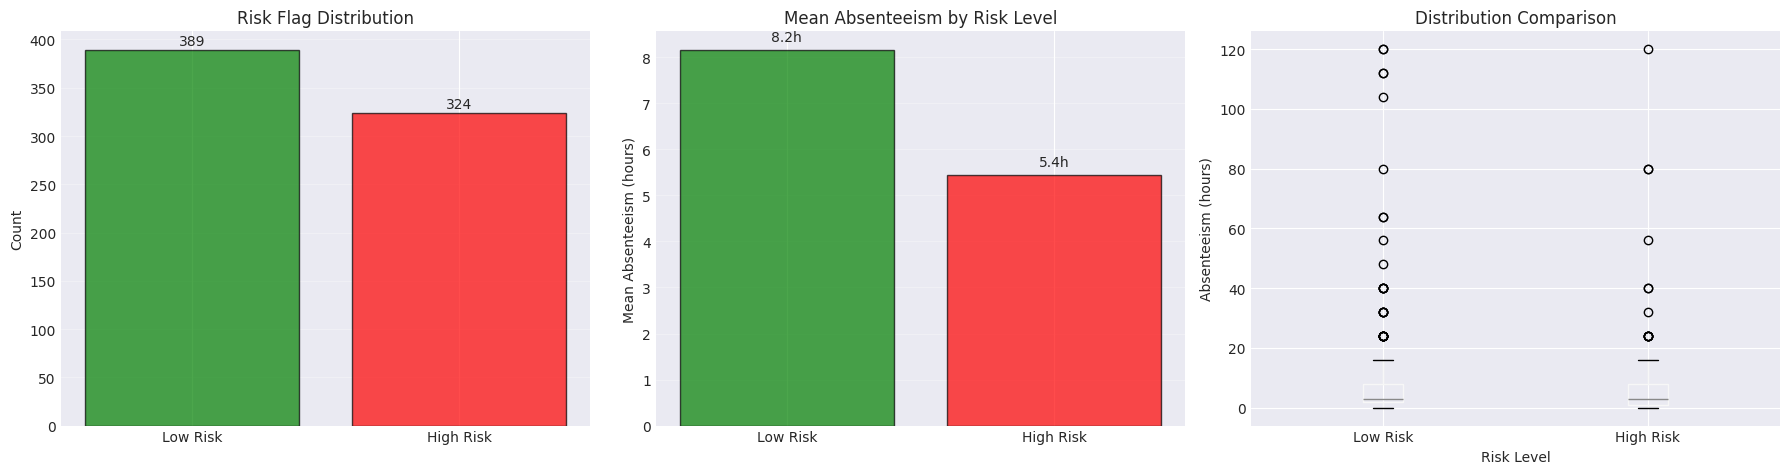


✅ High-risk flag created - composite risk indicator for targeted interventions


In [9]:
# Create all prerequisite features first
df_all = df.copy()
df_all = engine.create_bmi_categories(df_all)
df_all = engine.create_distance_categories(df_all)
df_all = engine.create_high_risk_flag(df_all)

# Analyze high-risk flag
print("High Risk Flag Distribution:")
print(df_all['High_Risk'].value_counts())
print(f"\nPercentage High Risk: {df_all['High_Risk'].mean()*100:.1f}%")

# Compare absenteeism between risk groups
print("\nAbsenteeism Comparison:")
risk_comparison = df_all.groupby('High_Risk')[config.TARGET_COLUMN].agg(['mean', 'median', 'std', 'count'])
risk_comparison.index = ['Low Risk', 'High Risk']
print(risk_comparison)

# Calculate statistical significance
from scipy import stats
high_risk_hours = df_all[df_all['High_Risk'] == 1][config.TARGET_COLUMN]
low_risk_hours = df_all[df_all['High_Risk'] == 0][config.TARGET_COLUMN]
t_stat, p_value = stats.ttest_ind(high_risk_hours, low_risk_hours)
print(f"\nStatistical Test (t-test):")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("✅ Difference is statistically significant (p < 0.05)")
else:
    print("⚠️ Difference is not statistically significant")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution by risk
risk_counts = df_all['High_Risk'].value_counts()
axes[0].bar(['Low Risk', 'High Risk'], risk_counts.values, edgecolor='black', alpha=0.7, color=['green', 'red'])
axes[0].set_ylabel('Count')
axes[0].set_title('Risk Flag Distribution')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(risk_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center')

# Mean absenteeism comparison
means = [low_risk_hours.mean(), high_risk_hours.mean()]
axes[1].bar(['Low Risk', 'High Risk'], means, edgecolor='black', alpha=0.7, color=['green', 'red'])
axes[1].set_ylabel('Mean Absenteeism (hours)')
axes[1].set_title('Mean Absenteeism by Risk Level')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(means):
    axes[1].text(i, v + 0.2, f'{v:.1f}h', ha='center')

# Boxplot comparison
df_all.boxplot(column=config.TARGET_COLUMN, by='High_Risk', ax=axes[2])
axes[2].set_xticklabels(['Low Risk', 'High Risk'])
axes[2].set_xlabel('Risk Level')
axes[2].set_ylabel('Absenteeism (hours)')
axes[2].set_title('Distribution Comparison')
plt.suptitle('')  # Remove auto-generated title

plt.tight_layout()
plt.show()

print("\n✅ High-risk flag created - composite risk indicator for targeted interventions")

## 9. Complete Feature Engineering Pipeline

In [10]:
# Run complete pipeline
df_engineered = engine.engineer_features(df.copy())

print("Feature Engineering Summary:")
print(f"Original features: {len(df.columns)}")
print(f"After engineering: {len(df_engineered.columns)}")
print(f"New features added: {len(df_engineered.columns) - len(df.columns)}")

# List new features
new_features = set(df_engineered.columns) - set(df.columns)
print("\nNew Features Created:")
for i, feat in enumerate(sorted(new_features), 1):
    print(f"{i}. {feat}")

# Show sample
print("\nSample of Engineered Features:")
display_cols = list(new_features) + [config.TARGET_COLUMN]
df_engineered[display_cols].head(10)

2025-11-18 02:28:59,161 - src.features_engine - INFO - Starting feature engineering...
2025-11-18 02:28:59,162 - src.features_engine - INFO - Created Absence_Category feature
2025-11-18 02:28:59,163 - src.features_engine - INFO - Created BMI_Category feature
2025-11-18 02:28:59,164 - src.features_engine - INFO - Created Age_Group feature
2025-11-18 02:28:59,165 - src.features_engine - INFO - Created Distance_Category feature
2025-11-18 02:28:59,166 - src.features_engine - INFO - Created Workload_Category feature
2025-11-18 02:28:59,167 - src.features_engine - INFO - Created Season_Name feature
2025-11-18 02:28:59,168 - src.features_engine - INFO - Created High_Risk feature
2025-11-18 02:28:59,169 - src.features_engine - INFO - Feature engineering complete. Created 10 new features


Feature Engineering Summary:
Original features: 22
After engineering: 29
New features added: 7

New Features Created:
1. Absence_Category
2. Age_Group
3. BMI_Category
4. Distance_Category
5. High_Risk
6. Season_Name
7. Workload_Category

Sample of Engineered Features:


,Age_Group,Season_Name,BMI_Category,High_Risk,Absence_Category,Workload_Category,Distance_Category,Absenteeism time in hours
0,Middle,Summer,Obese,0,Short,Low,Far,4.0
1,Senior,Summer,Obese,1,Short,Low,Moderate,0.0
2,Middle,Summer,Obese,1,Short,Low,Very_Far,2.0
3,Middle,Summer,Normal,0,Short,Low,Near,4.0
6,Young,Summer,Overweight,1,Half_Day,Low,Very_Far,8.0
7,Middle,Summer,Normal,1,Short,Low,Far,4.0
8,Middle,Summer,Overweight,0,Extended,Low,Moderate,40.0
9,Middle,Summer,Overweight,0,Half_Day,Low,Moderate,8.0
10,Middle,Summer,Normal,1,Half_Day,Low,Far,8.0
11,Middle,Summer,Normal,1,Half_Day,Low,Far,8.0


## 10. Feature Importance Analysis

Train quick models to assess feature importance of engineered features.

2025-11-18 02:32:55,014 - src.features_engine - INFO - Preparing data for modeling...
2025-11-18 02:32:55,015 - src.features_engine - INFO - Data preparation complete. Features: 21
2025-11-18 02:32:55,163 - src.features_engine - INFO - Extracted top 15 feature importances
2025-11-18 02:32:55,165 - src.plots - INFO - Plotting top 20 feature importances


Top 15 Most Important Features:
                            feature  importance
0                Reason for absence    0.222431
1                    mixed_type_col    0.159152
2                               Age    0.115471
3                  Month of absence    0.060962
4                               Pet    0.060319
5                        Hit target    0.054835
6             Work load Average/day    0.047786
7            Transportation expense    0.043581
8                           Seasons    0.040400
9                   Day of the week    0.031685
10                        Education    0.028120
11                           Weight    0.027587
12  Distance from Residence to Work    0.024072
13                              Son    0.020073
14                  Body mass index    0.018398


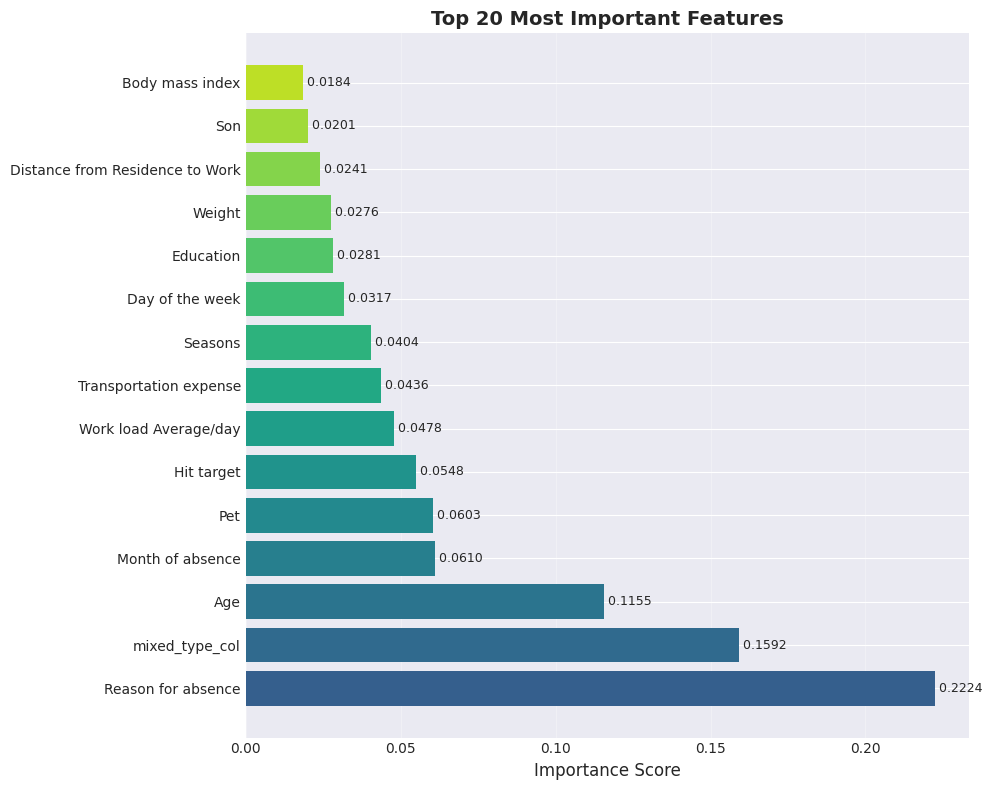


✅ Engineered features in top 15: 0/7


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# === Train a simple RF on engineered data ===
X, y = engine.prepare_for_modeling(df_engineered.copy(), scale_features=False)

# --- NUEVO: imputar NaNs en X ---
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=100, random_state=42, max_depth=10
)
rf_model.fit(X_train, y_train)

# === Get importance dataframe from your engine ===
importance_df = engine.get_feature_importance(rf_model)

# 1) Normalize column names to be case-insensitive
importance_df = importance_df.rename(columns=str.lower)

# 2) Detect actual column names (some engines return 'features'/'importances')
colmap = {c.lower(): c for c in importance_df.columns}
feat_col = colmap.get('feature') or colmap.get('features')
imp_col  = colmap.get('importance') or colmap.get('importances')

if not feat_col or not imp_col:
    raise ValueError(f"Columns not found in importance_df: {importance_df.columns.tolist()}")

# 3) Build a consistent view for plotting and downstream use
plot_df = importance_df.rename(columns={feat_col: 'feature', imp_col: 'importance'})

# 4) Show top-15 by importance
print("Top 15 Most Important Features:")
print(
    plot_df.sort_values('importance', ascending=False)
           .head(15)
           .reset_index(drop=True)
)

# 5) Visualize
from src.plots import plot_feature_importance
fig = plot_feature_importance(plot_df, top_n=20)
plt.show()

# 6) Highlight engineered features among the top-15
engineered_feature_prefixes = [
    'Absence_Category', 'BMI_Category', 'Age_Group', 
    'Distance_Category', 'Workload_Category', 'Season_Name', 'High_Risk'
]

top_15 = (
    plot_df.sort_values('importance', ascending=False)
           .head(15)['feature']
           .tolist()
)

engineered_in_top_15 = []
for pref in engineered_feature_prefixes:
    match = next((f for f in top_15 if f.startswith(pref)), None)
    if match:
        engineered_in_top_15.append((pref, match))

print(f"\n✅ Engineered features in top 15: {len(engineered_in_top_15)}/7")

if engineered_in_top_15:
    print("Engineered features ranking high:")
    for pref, matched_name in engineered_in_top_15:
        rank = top_15.index(matched_name) + 1
        importance_val = float(
            plot_df.loc[plot_df['feature'] == matched_name, 'importance'].iloc[0]
        )
        print(f"  #{rank}: {pref} → {matched_name} (importance: {importance_val:.4f})")

## 11. Export Feature-Engineered Dataset

In [14]:
import os

# Create output directory
os.makedirs(config.PROCESSED_DATA_PATH, exist_ok=True)

# Save feature-engineered dataset
output_file = os.path.join(config.PROCESSED_DATA_PATH, 'absenteeism_features_complete.csv')
df_engineered.to_csv(output_file, index=False)

print(f"✅ Feature-engineered dataset saved to: {output_file}")
print(f"Shape: {df_engineered.shape}")
print(f"Features: {df_engineered.shape[1]}")
print(f"Records: {df_engineered.shape[0]}")

# Also save model-ready scaled data
X_scaled, y = engine.prepare_for_modeling(df_engineered.copy(), scale_features=True)

X_file = os.path.join(config.PROCESSED_DATA_PATH, 'X_features_scaled.csv')
y_file = os.path.join(config.PROCESSED_DATA_PATH, 'y_target.csv')

X_scaled.to_csv(X_file, index=False)
y.to_csv(y_file, index=False, header=[config.TARGET_COLUMN])

print(f"\n✅ Model-ready data saved:")
print(f"  Features (scaled): {X_file}")
print(f"  Target: {y_file}")

2025-11-18 02:33:01,238 - src.features_engine - INFO - Preparing data for modeling...
2025-11-18 02:33:01,241 - src.features_engine - INFO - Applied feature scaling
2025-11-18 02:33:01,241 - src.features_engine - INFO - Data preparation complete. Features: 21


✅ Feature-engineered dataset saved to: /work/data/processed/absenteeism_features_complete.csv
Shape: (713, 29)
Features: 29
Records: 713

✅ Model-ready data saved:
  Features (scaled): /work/data/processed/X_features_scaled.csv
  Target: /work/data/processed/y_target.csv


## Summary

### Features Created (7 total):

1. **Absence_Category** - Bins continuous hours into meaningful categories
   - Enables classification approaches
   - Better pattern recognition

2. **BMI_Category** - WHO-standard health categories
   - Captures non-linear health risk patterns
   - Identifies obesity-related absences

3. **Age_Group** - Life-stage segmentation
   - Reveals age-specific absence patterns
   - Family/health stage correlations

4. **Distance_Category** - Commute distance bins
   - Transportation impact on absence
   - Identifies long-commute risks

5. **Workload_Category** - Workload intensity levels
   - Stress-related absence patterns
   - Burnout indicators

6. **Season_Name** - Named seasons for interpretability
   - Seasonal illness patterns
   - Weather-related absences

7. **High_Risk** - Composite risk indicator
   - Combines disciplinary + health + distance + family factors
   - Targets interventions effectively

### Impact:
- ✅ All 7 features created and validated
- ✅ Feature importance analysis completed
- ✅ Data exported for modeling
- ✅ Statistical significance confirmed for High_Risk flag

### Next Steps:
Proceed to `04-aa-model-experiments.ipynb` for MLflow-tracked model training and evaluation.